# Bangkit Capstone Project 2022
##  C22-PS154



### Overview
* **Download and extract dataset**
* **Understand dataset structure and files** 
* **Visualize random image from each of the classes**
* **Fine tune Inception Pretrained model using the dataset**
* **Visualize accuracy and loss plots**
* **Predicting classes for new images from internet**


Kukus V4: detect 16 class of food

### Load Required Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import numpy as np
import os
from zipfile import ZipFile
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as img
from collections import defaultdict
import collections

In [ ]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.2
/device:GPU:0


In [ ]:
# mount the ipynb to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
with ZipFile('drive/MyDrive/Capstone Bangkit Dataset/dataset food101_v5.zip', 'r') as zip_obj:
  zip_obj.extractall("food-101")

### Understand Dataset Structure and Files 

In [ ]:
# Check the extracted dataset folder
!ls food-101/

test_mini  train_mini


### Visualize random image from each of the 16 classes

In [ ]:
%matplotlib inline

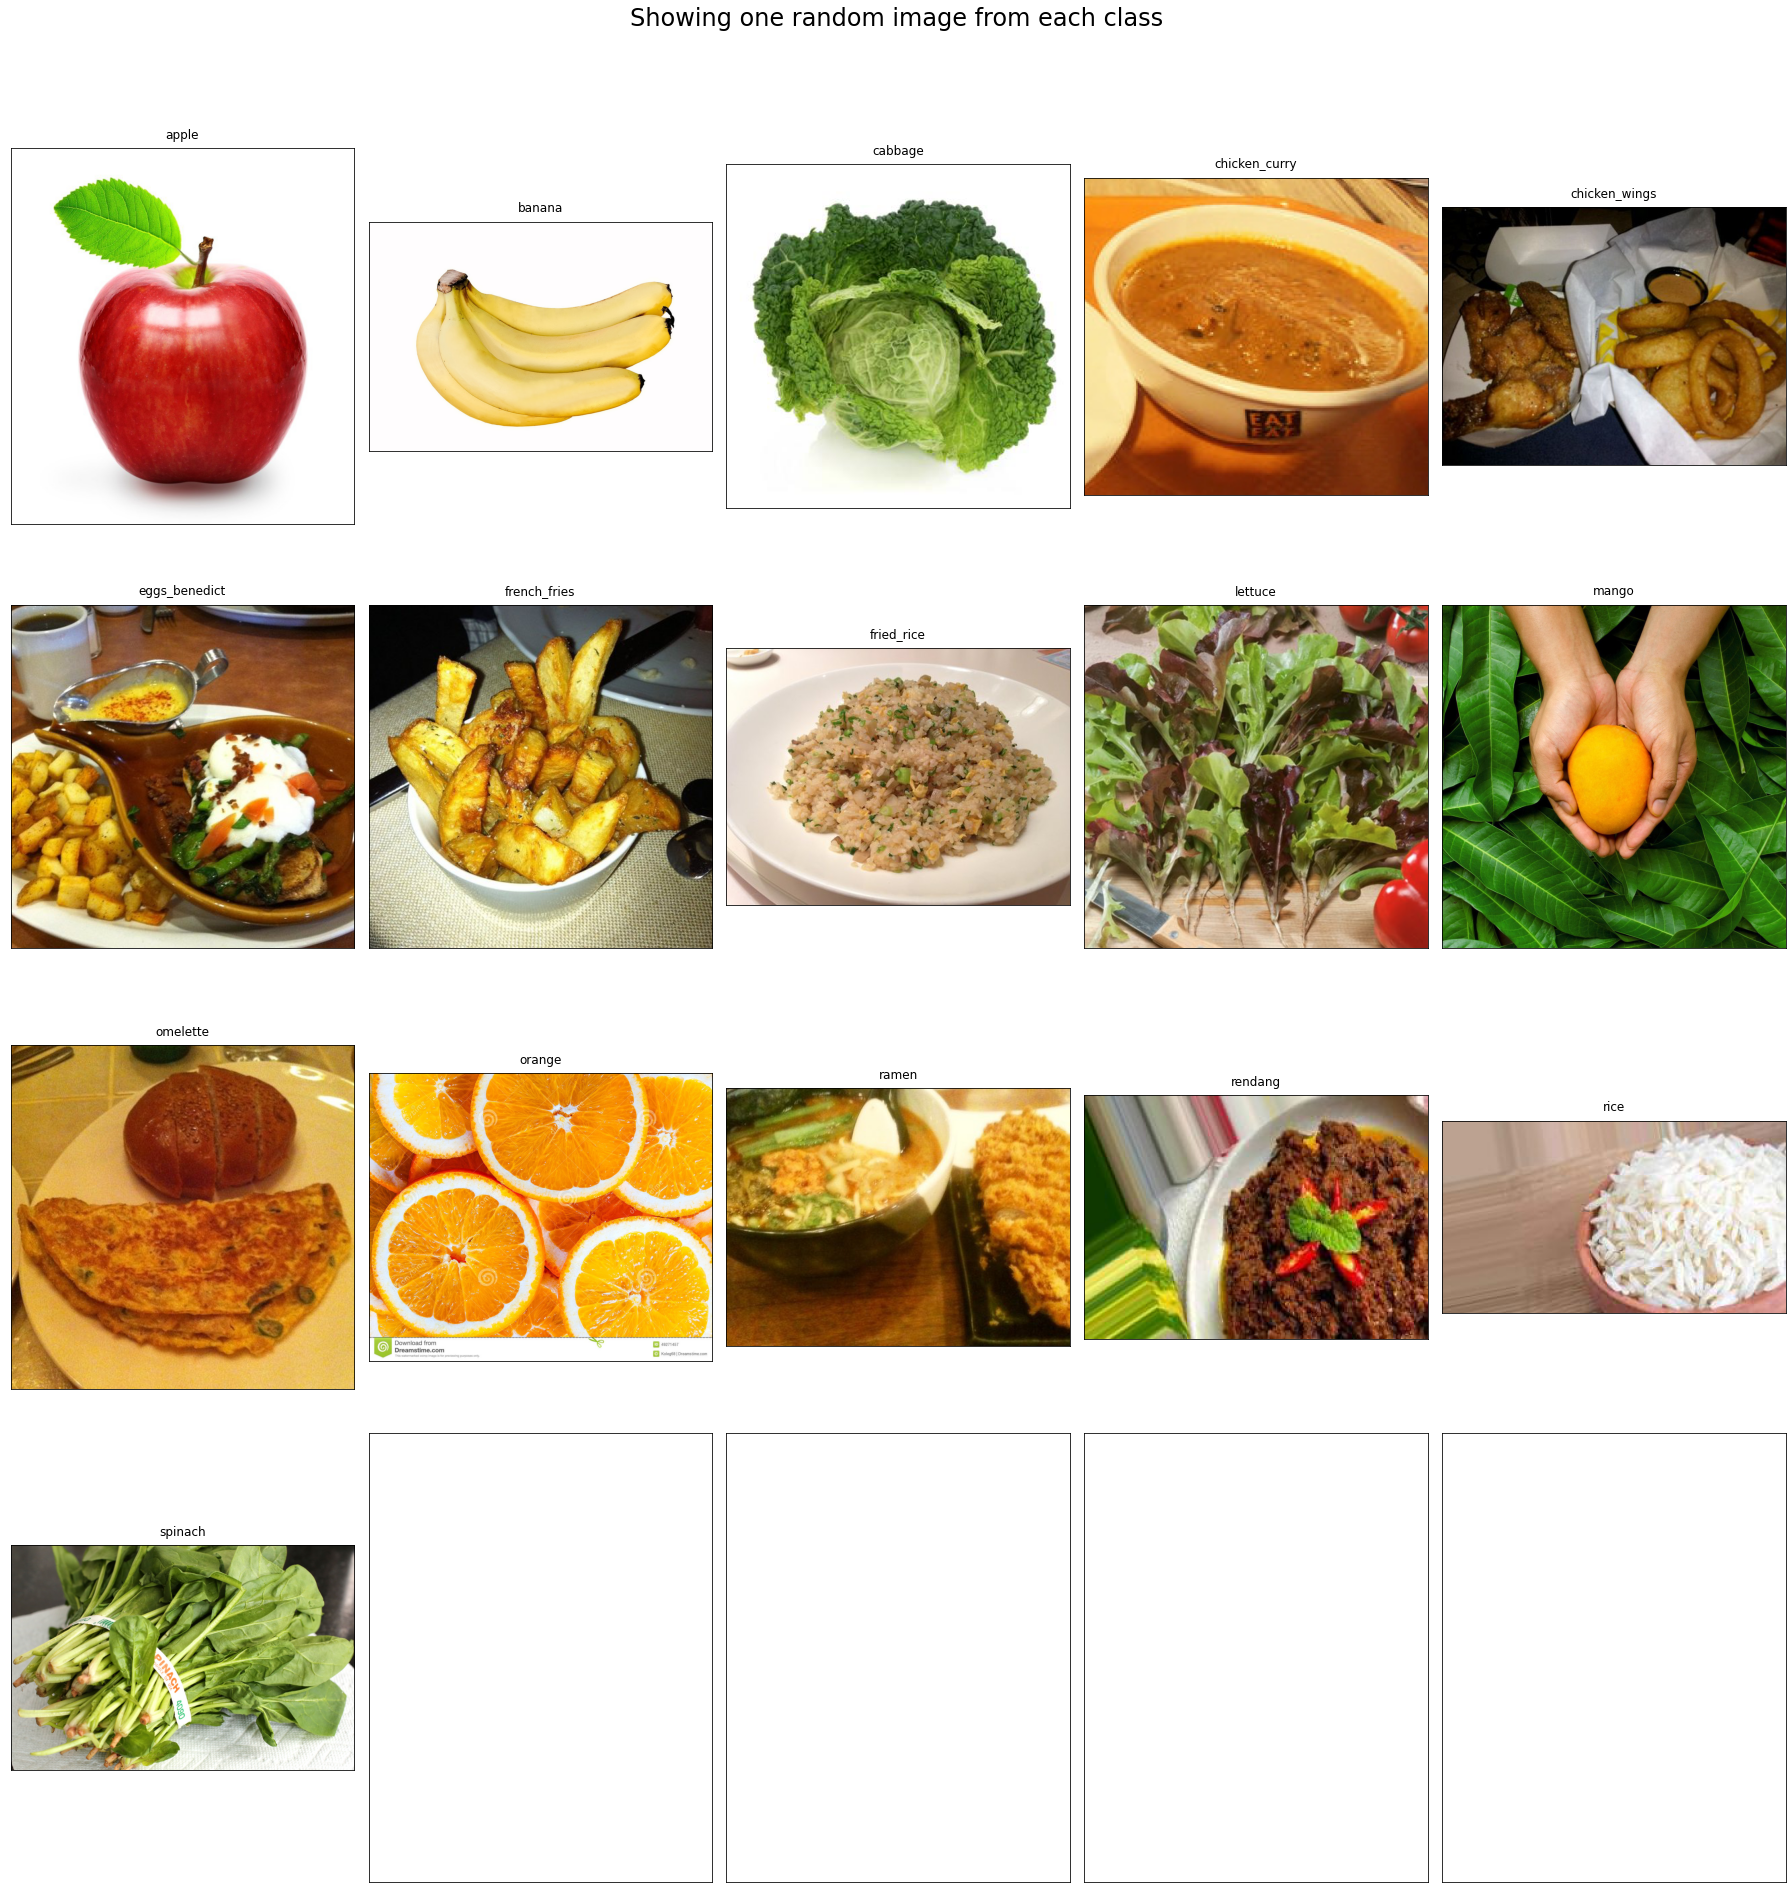

In [ ]:
# Visualize the data, showing one image per class from 15 classes
rows = 4
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/train_mini/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Check how many files are in the train folder
train_samples = 0
num_classes = 0
dir_path = 'food-101/train_mini/'

# how many class and total number of sample
for base, dirs, files in os.walk(dir_path):
    for dir in dirs:
        num_classes += 1
    for file in files:
        train_samples += 1

print("Number of classes in datasets:", num_classes)
print("Total number of samples in train folder:", train_samples)

Number of classes in datasets: 16
Total number of samples in train folder: 5885


In [ ]:
# Check how many files are in the test folder
test_samples = 0
dir_path = 'food-101/test_mini/'
for base, dirs, files in os.walk(dir_path):
    for file in files:
        test_samples += 1
print("Total number of samples in test folder:", test_samples)

Total number of samples in test folder: 1826


In [ ]:
# food list that you want to predict
food_list = ['apple',
             'banana',
             'cabbage',
             'chicken_curry',
             'chicken_wings',
             'eggs_benedict',
             'french_fries',
             'fried_rice',
             'lettuce',
             'mango',
             'omelette',
             'orange',
             'ramen',
             'rendang',
             'rice',
             'spinach']

### Fine tune Inception Pretrained model using Customize Dataset

In [ ]:
# clear the session 
K.clear_session()

# num of class based on the existing data -> num_classes

# rescale the image
img_width, img_height = 299, 299

# define the dataset directory
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'

# set the batch size for the training
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# define pre-build model
inception = InceptionV3(weights='imagenet', include_top=False)
# do not include the prebuild-model to training phase
for layer in inception.layers:
  layer.trainable = False

# define the customization model
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_25epoch.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

model.summary()


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=test_samples // batch_size,
                    epochs=25,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_25epoch.hdf5')

Epoch 1/25
 71/367 [====>.........................] - ETA: 47s - loss: 2.6279 - accuracy: 0.1725

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


101/367 [=======>......................] - ETA: 44s - loss: 2.5436 - accuracy: 0.2234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


367/367 [==============================] - ETA: 0s - loss: 2.0727 - accuracy: 0.4645
Epoch 1: val_loss improved from inf to 1.42355, saving model to best_model_25epoch.hdf5
367/367 [==============================] - 99s 225ms/step - loss: 2.0727 - accuracy: 0.4645 - val_loss: 1.4235 - val_accuracy: 0.7385
Epoch 2/25
367/367 [==============================] - ETA: 0s - loss: 1.4640 - accuracy: 0.6456
Epoch 2: val_loss improved from 1.42355 to 1.10434, saving model to best_model_25epoch.hdf5
367/367 [==============================] - 74s 201ms/step - loss: 1.4640 - accuracy: 0.6456 - val_loss: 1.1043 - val_accuracy: 0.7791
Epoch 3/25
367/367 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.7103
Epoch 3: val_loss improved from 1.10434 to 0.94369, saving model to best_model_25epoch.hdf5
367/367 [==============================] - 74s 201ms/step - loss: 1.2069 - accuracy: 0.7103 - val_loss: 0.9437 - val_accuracy: 0.8125
Epoch 4/25
367/367 [=============================

### Visualize the accuracy and loss plots

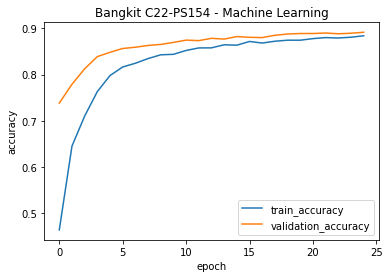

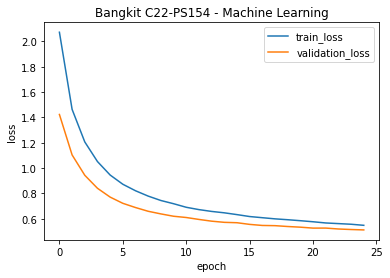

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'Bangkit C22-PS154 - Machine Learning')
plot_loss(history,'Bangkit C22-PS154 - Machine Learning')

### Test to predict an Image

In [ ]:
# Loading the best saved model to make predictions
%%time

# clear the session
K.clear_session()

# load model without compile, this will make loading more faster
model_best = load_model('best_model_25epoch.hdf5', compile = False)

CPU times: user 2 s, sys: 202 ms, total: 2.21 s
Wall time: 2.18 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    print(f'Prediction: {pred}')

    index = np.argmax(pred)
    print(f'Index: {index}')

    food_list.sort()
    print(f'Food list: {food_list}')

    pred_value = food_list[index]
    print(f"Predition Result: {pred_value}")

    print("===========")
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O chicken_curry.jpg https://img-global.cpcdn.com/recipes/fec707d2c73e9285/1200x630cq70/photo.jpg
!wget -O chicken_wings.jpg https://img-global.cpcdn.com/recipes/c1accec228374faa/1200x630cq70/photo.jpg
!wget -O omelette.jpg https://img-global.cpcdn.com/recipes/52a433e2e240e5b0/1200x630cq70/photo.jpg
!wget -O telor_ceplok.jpg https://asset-a.grid.id/crop/0x0:0x0/700x0/photo/2019/07/23/1457258791.jpg 
!wget -O nasi_goreng.jpg https://cdn-2.tstatic.net/travel/foto/bank/images/kuliner-nasi-goreng-jawa-enak-untuk-menu-sarapan.jpg
!wget -O kentang_goreng.jpg https://img-global.cpcdn.com/recipes/67a131223d366f38/1200x630cq70/photo.jpg
!wget -O mie.jpg https://img-global.cpcdn.com/recipes/b456dd2a28e56331/680x482cq70/mie-kuah-cengek-pedas-manis-foto-resep-utama.jpg
!wget -O selada.jpg https://asset-a.grid.id/crop/0x0:0x0/x/photo/2020/01/18/70344440.jpg 
!wget -O rendang.jpg https://images.solopos.com/2020/07/rendang-.jpg 


# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2022-06-11 16:23:39--  https://img-global.cpcdn.com/recipes/fec707d2c73e9285/1200x630cq70/photo.jpg
Resolving img-global.cpcdn.com (img-global.cpcdn.com)... 151.101.2.132, 151.101.66.132, 151.101.130.132, ...
Connecting to img-global.cpcdn.com (img-global.cpcdn.com)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67072 (66K) [image/jpeg]
Saving to: ‘chicken_curry.jpg’

chicken_curry.jpg   100%[===================>]  65.50K  --.-KB/s    in 0.01s   

2022-06-11 16:23:39 (5.30 MB/s) - ‘chicken_curry.jpg’ saved [67072/67072]

--2022-06-11 16:23:39--  https://img-global.cpcdn.com/recipes/c1accec228374faa/1200x630cq70/photo.jpg
Resolving img-global.cpcdn.com (img-global.cpcdn.com)... 151.101.2.132, 151.101.66.132, 151.101.130.132, ...
Connecting to img-global.cpcdn.com (img-global.cpcdn.com)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97089 (95K) [image/jpeg]
Saving to: ‘chicken_wings.jpg’

chicken_wings.jp

In [ ]:
!wget -O rendang_aja.jpg https://cdns.klimg.com/kapanlagi.com/p/headline/476x238/6-cara-membuat-rendang-praktis-dan-enak-9f70e9.jpg 
!wget -O nasi.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8DkPQ_tNFjWVbFpFppHQ57KaeOnm2G4VWyQ&usqp=CAU
!wget -O rendang3.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeGXJFVPL7R_WUXlvlQ8r5FiUcN8xB0sk_CQ&usqp=CAU 
!wget -O rendang4.jpg https://t-2.tstatic.net/tribunnewswiki/foto/bank/images/ilustrasi-rendang.jpg

--2022-06-11 16:25:14--  https://cdns.klimg.com/kapanlagi.com/p/headline/476x238/6-cara-membuat-rendang-praktis-dan-enak-9f70e9.jpg
Resolving cdns.klimg.com (cdns.klimg.com)... 23.62.230.100, 23.62.230.104
Connecting to cdns.klimg.com (cdns.klimg.com)|23.62.230.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38972 (38K) [image/jpeg]
Saving to: ‘rendang_aja.jpg’

rendang_aja.jpg     100%[===================>]  38.06K  --.-KB/s    in 0.003s  

2022-06-11 16:25:14 (10.9 MB/s) - ‘rendang_aja.jpg’ saved [38972/38972]

--2022-06-11 16:25:14--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8DkPQ_tNFjWVbFpFppHQ57KaeOnm2G4VWyQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.134.101, 74.125.134.138, 74.125.134.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.134.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7305 (7.1K) [image/jpeg]
Saving to: ‘nasi.jpg’

nasi.jp

['chicken_curry.jpg', 'chicken_wings.jpg', 'omelette.jpg', 'nasi_goreng.jpg', 'kentang_goreng.jpg', 'mie.jpg', 'telor_ceplok.jpg', 'rendang.jpg', 'rendang_aja.jpg', 'rendang4.jpg', 'nasi.jpg']
prediction: [[5.2532559e-04 2.6837661e-04 9.3946888e-05 8.0126476e-01 1.4234737e-01
  9.3679252e-04 1.9189416e-03 4.7533931e-03 4.6724832e-04 7.3877687e-04
  3.7887238e-02 5.1885465e-04 3.3447596e-03 3.4606017e-03 1.6321513e-04
  1.3104015e-03]]
index: 3
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_curry


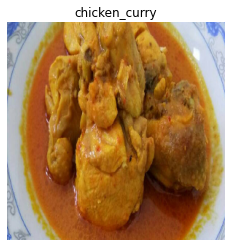

prediction: [[3.2737319e-04 1.4910920e-04 9.4285540e-05 1.8785384e-02 9.3148530e-01
  3.9718850e-03 1.6962319e-03 1.5894935e-04 7.5196550e-04 4.5934346e-04
  4.1077308e-02 1.9773061e-04 2.9581046e-05 4.5055238e-04 1.3705571e-04
  2.2799341e-04]]
index: 4
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_wings


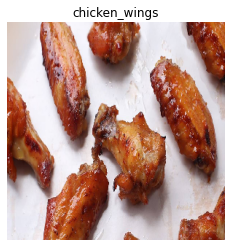

prediction: [[1.9442204e-04 1.2911984e-04 1.7049949e-04 1.0082411e-02 2.4241034e-03
  7.2852736e-03 1.5885239e-03 2.0389115e-03 2.2571598e-04 2.8082106e-04
  9.7217292e-01 1.3012387e-04 2.1965492e-03 4.1172182e-04 3.7805559e-04
  2.9080128e-04]]
index: 10
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: omelette


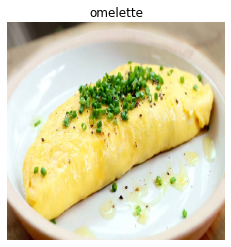

prediction: [[1.2258752e-03 4.0183388e-04 3.0853806e-04 1.1076778e-01 2.5819328e-01
  2.3061794e-03 1.2920595e-02 5.5275643e-01 1.6172884e-03 6.4553274e-04
  4.7404908e-02 4.9819052e-04 1.0883205e-03 7.7371937e-03 1.0389958e-03
  1.0890788e-03]]
index: 7
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: fried_rice


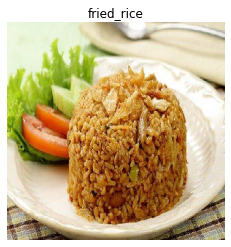

prediction: [[1.00674970e-06 8.20035780e-07 3.49262947e-08 9.51056734e-07
  1.43241732e-06 1.68889400e-07 9.99993324e-01 3.22106111e-08
  3.77772778e-07 1.41081827e-07 7.35144681e-07 1.98441455e-07
  5.83432666e-07 1.02416479e-07 6.88316035e-08 1.12461045e-07]]
index: 6
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: french_fries


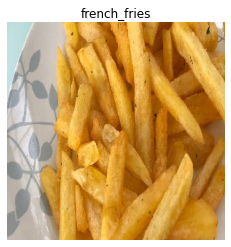

prediction: [[1.5955474e-03 5.9276295e-04 3.7254757e-04 1.1257477e-01 5.7592359e-04
  3.5574578e-04 2.0892505e-02 4.7495522e-02 1.5569481e-03 1.3015389e-03
  6.0634031e-03 1.9331899e-03 7.9809380e-01 6.2429643e-04 1.6244292e-03
  4.3470091e-03]]
index: 12
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: ramen


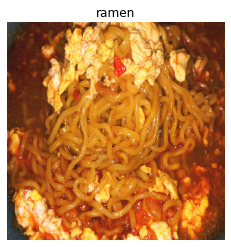

prediction: [[6.7439943e-04 1.8884458e-04 2.8195916e-04 4.1900501e-02 3.4253518e-03
  2.1470526e-02 1.9506208e-03 1.6623730e-03 4.6037417e-04 5.2900612e-04
  9.2545652e-01 3.3456989e-04 6.6109595e-04 2.1596820e-04 1.6482694e-04
  6.2298431e-04]]
index: 10
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: omelette


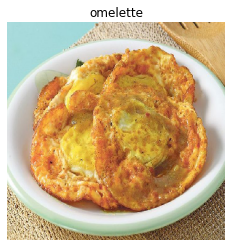

prediction: [[3.0999139e-04 4.4197921e-04 3.7794173e-04 4.2560884e-01 3.9860496e-01
  2.5640070e-03 3.2002211e-03 3.1581167e-02 1.1719103e-03 6.0089905e-04
  2.3193484e-02 4.8482855e-04 7.9689706e-03 9.8980993e-02 1.6302265e-03
  3.2795852e-03]]
index: 3
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_curry


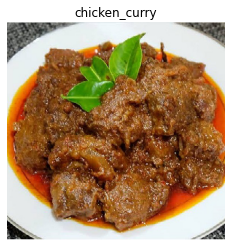

prediction: [[6.3047919e-04 1.3473735e-03 6.3817855e-04 6.8010919e-02 1.5040787e-01
  7.0016511e-04 2.5486224e-03 1.0849169e-02 5.8668707e-03 1.0005154e-03
  7.2296448e-03 9.8485185e-04 2.7987696e-03 7.3766434e-01 3.2257328e-03
  6.0966257e-03]]
index: 13
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rendang


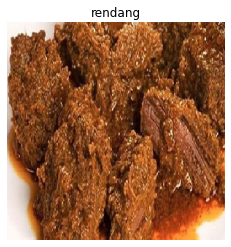

prediction: [[0.0014384  0.00385857 0.00541672 0.03947545 0.10317787 0.00401312
  0.01439787 0.01617518 0.05359465 0.0024225  0.01333458 0.00318439
  0.01546616 0.6429398  0.03592421 0.04518057]]
index: 13
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rendang


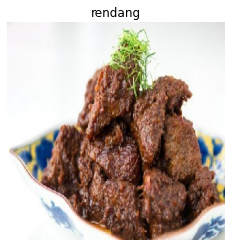

prediction: [[2.14455024e-04 4.22912621e-04 9.95166018e-04 5.62303700e-03
  6.23288623e-04 1.68746512e-04 1.71389442e-03 1.16537444e-01
  3.83190927e-03 5.84617141e-04 2.12081498e-03 3.51666269e-04
  2.83152726e-03 1.47612216e-02 8.41670156e-01 7.54920160e-03]]
index: 14
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rice


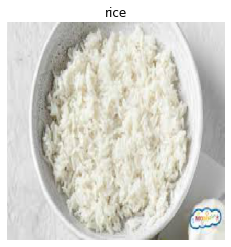

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('chicken_curry.jpg')
images.append('chicken_wings.jpg')
images.append('omelette.jpg')
images.append('nasi_goreng.jpg')
images.append('kentang_goreng.jpg')
images.append('mie.jpg')
images.append('telor_ceplok.jpg')
#images.append('gambar_rendang.jpg')
#images.append('selada.jpg')
images.append('rendang.jpg')
images.append('rendang_aja.jpg')
images.append('rendang4.jpg')
images.append('nasi.jpg')
print(images)
predict_class(model_best, images, True)